# Estimation of Navier-Stokes equation
## Done by: Andreea-Ioana Florea

In [1]:
print("Hello, world!!!")

Hello, world!!!


In [2]:
import tensorflow as tf
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


In [3]:
# Physical parameters
rho = 1  # Density
mu = 1   # Viscosity
u_in = 1
D = 1
L = 2

# Define geometry: A rectangle
#geom = dde.geometry.Rectangle(xmin=[-L / 2, -D / 2], xmax=[L / 2, D / 2])
# Main channel
channel = dde.geometry.Rectangle(xmin=[-L / 2, -D / 2], xmax=[L / 2, D / 2])

# Obstacle (Cylinder)
center = [0, 0]
radius = 0.1
cylinder = dde.geometry.Disk(center, radius)

# Combined geometry
geom = channel - cylinder

# 1. Define the Heart Shape coordinates
t = np.linspace(0, 2 * np.pi, 100)
# Parametric heart equations scaled down to size 0.1
heart_x = 0.1 * (16 * np.sin(t)**3) / 16
heart_y = 0.1 * (13 * np.cos(t) - 5 * np.cos(2*t) - 2 * np.cos(3*t) - np.cos(4*t)) / 16

# Shift the heart to the LEFT of the center (x = -0.5)
heart_points = np.vstack([heart_x - 0.5, heart_y]).T
heart_shape = dde.geometry.Polygon(heart_points)

# 2. Define the Cylinder and Channel
channel = dde.geometry.Rectangle(xmin=[-L / 2, -D / 2], xmax=[L / 2, D / 2])
cylinder = dde.geometry.Disk([0, 0], 0.1)

# 3. Combine: Subtract BOTH from the channel
# This creates a channel with two holes
geom = channel - cylinder - heart_shape

C:\Users\andre\.conda\envs\challenge_Navier_Stokes_ResNet\lib\site-packages\deepxde\geometry\geometry_2d.py:814: RuntimeWarning: invalid value encountered in divide
  self.normal = self.normal / np.linalg.norm(self.normal, axis=1).reshape(-1, 1)


In [4]:
# Define boundary conditions
def boundary_wall(X, on_boundary):
    on_wall = np.logical_and(
        np.logical_or(
            np.isclose(X[1], -D / 2, rtol=1e-05, atol=1e-08),
            np.isclose(X[1], D / 2, rtol=1e-05, atol=1e-08),
        ),
        on_boundary,
    )
    return on_wall

def boundary_inlet(X, on_boundary):
    on_inlet = np.logical_and(
        np.isclose(X[0], -L / 2, rtol=1e-05, atol=1e-08), on_boundary
    )
    return on_inlet

def boundary_outlet(X, on_boundary):
    on_outlet = np.logical_and(
        np.isclose(X[0], L / 2, rtol=1e-05, atol=1e-08), on_boundary
    )
    return on_outlet

def boundary_cylinder(X, on_boundary):
    # Check if the point is on the boundary and NOT on the outer channel walls
    return on_boundary and not (
        np.isclose(X[0], -L/2) or np.isclose(X[0], L/2) or
        np.isclose(X[1], -D/2) or np.isclose(X[1], D/2)
    )

def boundary_obstacles(X, on_boundary):
    # Logic: It's an obstacle if it's on a boundary but NOT the external box edges
    on_outer_wall = np.logical_or(
        np.logical_or(np.isclose(X[0], -L/2), np.isclose(X[0], L/2)),
        np.logical_or(np.isclose(X[1], -D/2), np.isclose(X[1], D/2))
    )
    return on_boundary and not on_outer_wall

# No-slip for all internal objects
bc_obs_u = dde.DirichletBC(geom, lambda X: 0.0, boundary_obstacles, component=0)
bc_obs_v = dde.DirichletBC(geom, lambda X: 0.0, boundary_obstacles, component=1)

bc_cylinder_u = dde.DirichletBC(geom, lambda X: 0.0, boundary_cylinder, component=0)
bc_cylinder_v = dde.DirichletBC(geom, lambda X: 0.0, boundary_cylinder, component=1)

bc_wall_u = dde.DirichletBC(geom, lambda X: 0.0, boundary_wall, component=0)
bc_wall_v = dde.DirichletBC(geom, lambda X: 0.0, boundary_wall, component=1)

bc_inlet_u = dde.DirichletBC(geom, lambda X: u_in, boundary_inlet, component=0)
bc_inlet_v = dde.DirichletBC(geom, lambda X: 0.0, boundary_inlet, component=1)

bc_outlet_p = dde.DirichletBC(geom, lambda X: 0.0, boundary_outlet, component=2)
bc_outlet_v = dde.DirichletBC(geom, lambda X: 0.0, boundary_outlet, component=1)

In [5]:
# Define PDE system
def pde(X, Y):
    """Args:
    Y: network output [u, v, p],
    X: input coordinates [x, y]"""
    du_x = dde.grad.jacobian(Y, X, i=0, j=0)
    du_y = dde.grad.jacobian(Y, X, i=0, j=1)
    dv_x = dde.grad.jacobian(Y, X, i=1, j=0)
    dv_y = dde.grad.jacobian(Y, X, i=1, j=1)
    dp_x = dde.grad.jacobian(Y, X, i=2, j=0)
    dp_y = dde.grad.jacobian(Y, X, i=2, j=1)

    du_xx = dde.grad.hessian(Y, X, component=0, i=0, j=0)
    du_yy = dde.grad.hessian(Y, X, component=0, i=1, j=1)
    dv_xx = dde.grad.hessian(Y, X, component=1, i=0, j=0)
    dv_yy = dde.grad.hessian(Y, X, component=1, i=1, j=1)

    pde_u = Y[:, 0:1] * du_x + Y[:, 1:2] * du_y + 1 / rho * dp_x - (mu / rho) * (du_xx + du_yy)
    pde_v = Y[:, 0:1] * dv_x + Y[:, 1:2] * dv_y + 1 / rho * dp_y - (mu / rho) * (dv_xx + dv_yy)
    pde_cont = du_x + dv_y


    return [pde_u, pde_v, pde_cont]

In [6]:
data = dde.data.PDE(
    geom,
    pde,
    [
        bc_wall_u, bc_wall_v,
        bc_inlet_u, bc_inlet_v,
        bc_outlet_p, bc_outlet_v,
        bc_obs_u, bc_obs_v  # Applies to both Heart and Cylinder
    ],
    num_domain=3000,    # Increase domain points for more detail
    num_boundary=600,   # Increase boundary points to define the heart edges
    num_test=200,
)

C:\Users\andre\.conda\envs\challenge_Navier_Stokes_ResNet\lib\site-packages\deepxde\geometry\geometry_2d.py:920: RuntimeWarning: invalid value encountered in divide
  v = (self.vertices[i + 1] - self.vertices[i]) / self.diagonals[i, i + 1]


In [7]:
# Define neural network
net = dde.maps.FNN([2] + [64] * 5 + [3], "tanh", "Glorot uniform")
model = dde.Model(data, net)

In [8]:
# Compile and train
model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(epochs=500)

Compiling model...
'compile' took 0.026729 s

Training model...

Cause: could not parse the source code of <function <lambda> at 0x0000013AB95C9360>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary1(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary2(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x0000013AB95C9360>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary1(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary2(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @

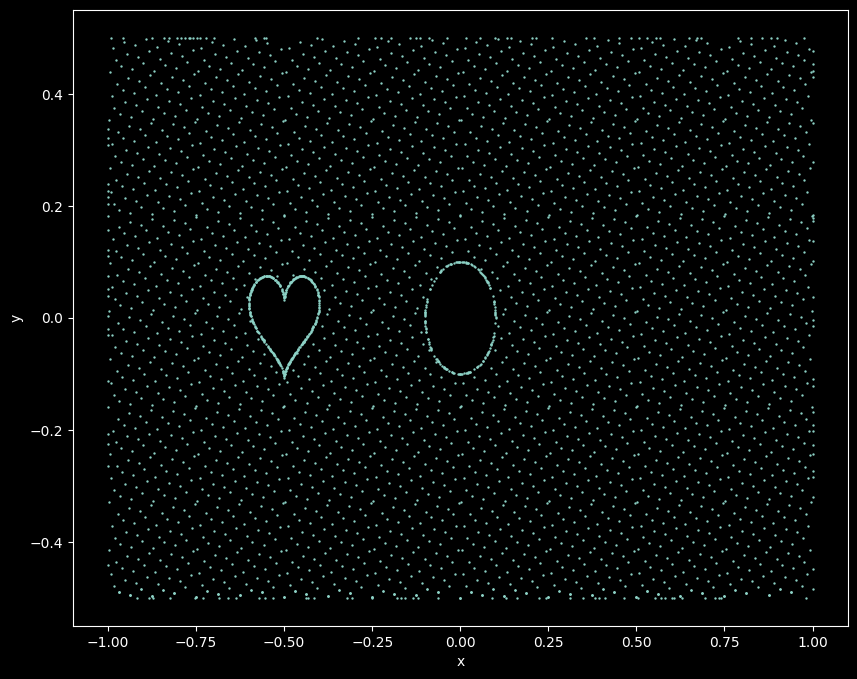

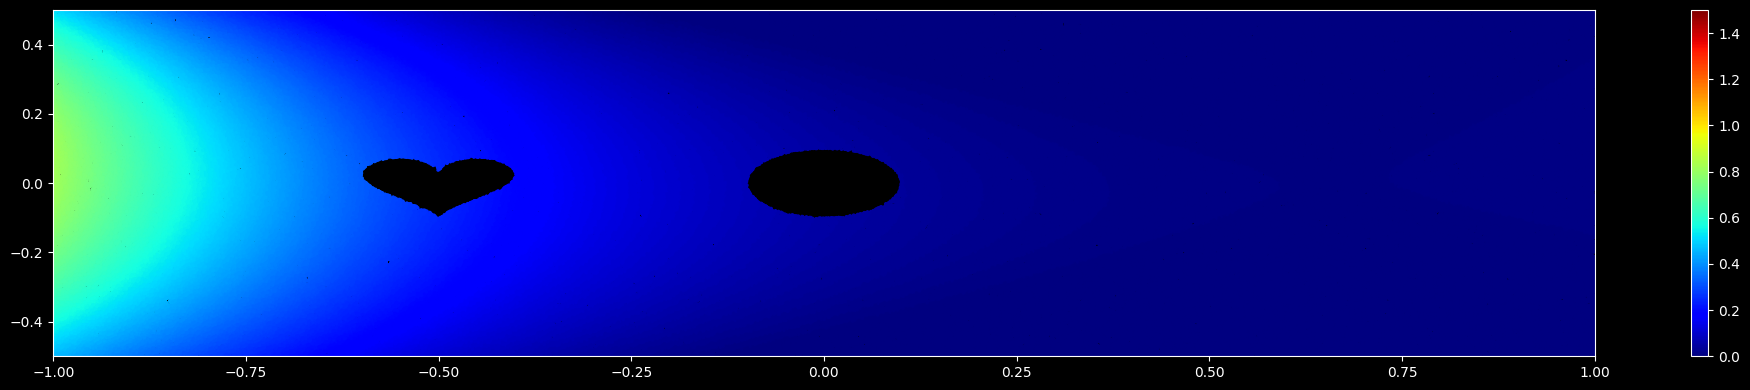

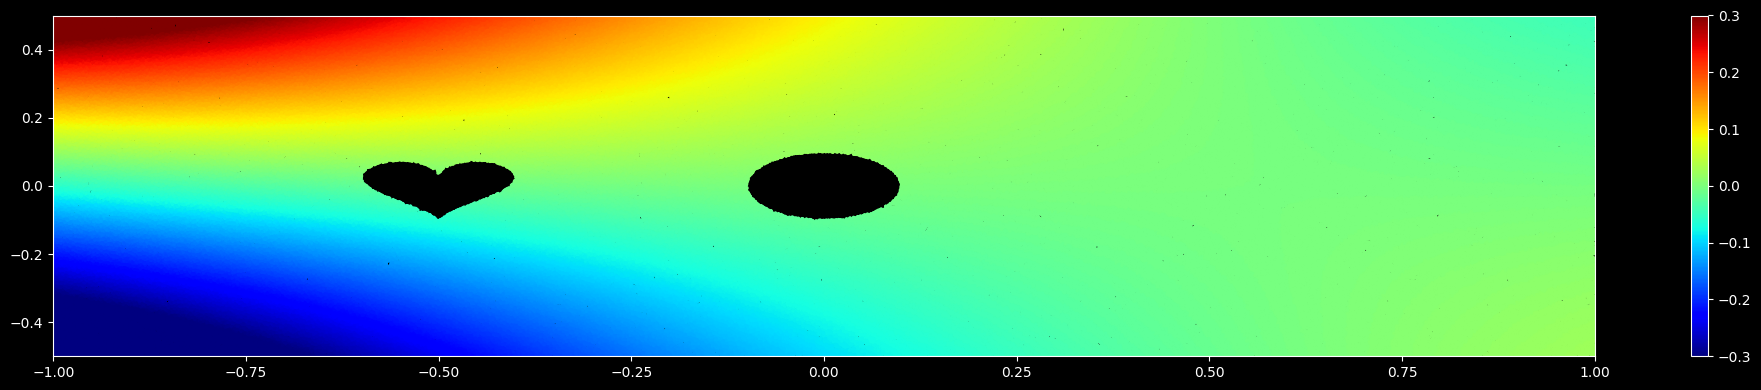

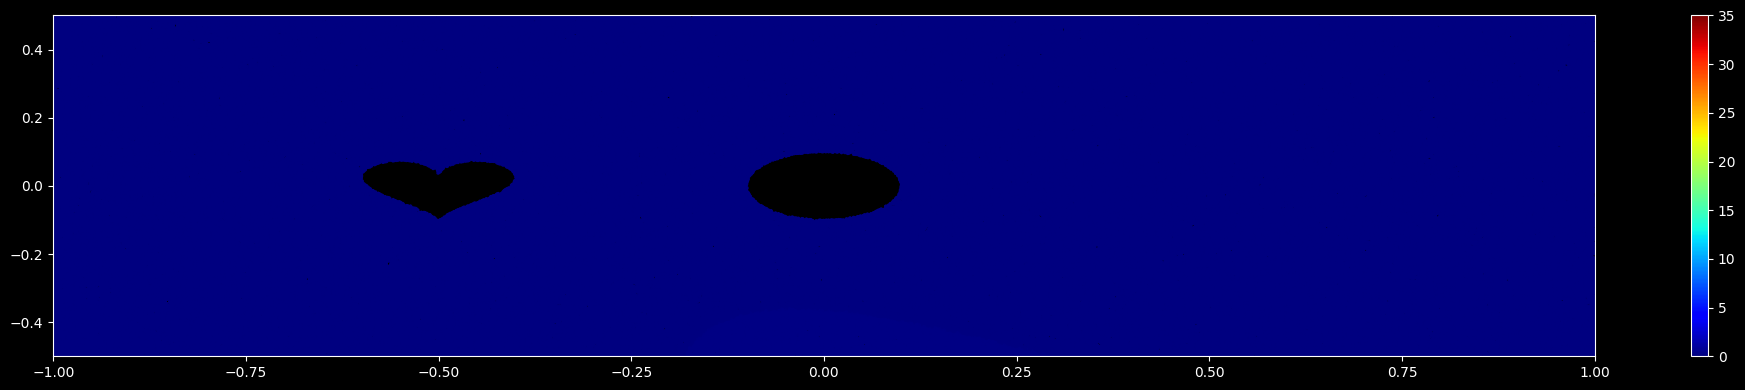

In [9]:
# Visualize training points
plt.figure(figsize=(10, 8))
plt.scatter(data.train_x_all[:, 0], data.train_x_all[:, 1], s=0.5)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Predict and plot results
samples = geom.random_points(500000)
result = model.predict(samples)

color_legend = [[0, 1.5], [-0.3, 0.3], [0, 35]]
for idx in range(3):
    plt.figure(figsize=(20, 4))
    plt.scatter(samples[:, 0], samples[:, 1], c=result[:, idx], cmap="jet", s=2)
    plt.colorbar()
    plt.clim(color_legend[idx])
    plt.xlim((0 - L / 2, L - L / 2))
    plt.ylim((0 - D / 2, D - D / 2))
    plt.tight_layout()
    plt.show()

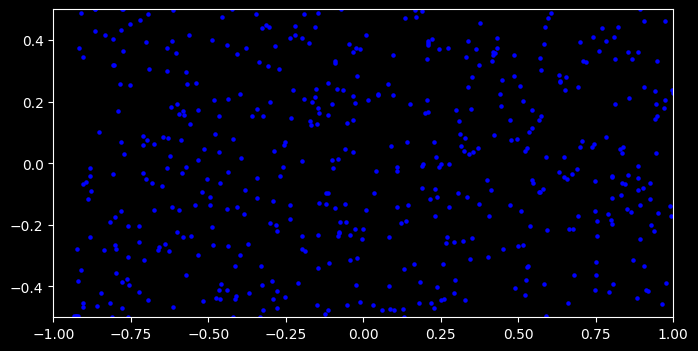

In [10]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from scipy.interpolate import griddata

# Prepare a grid for interpolation
samples = geom.random_points(5000)  # same as before
result = model.predict(samples)      # predict only for these points

u = result[:, 0]
v = result[:, 1]


# Interpolate velocity on a regular grid
grid_x, grid_y = np.meshgrid(np.linspace(-L/2, L/2, 200), np.linspace(-D/2, D/2, 200))
grid_u = griddata(samples, u, (grid_x, grid_y), method='cubic', fill_value=0)
grid_v = griddata(samples, v, (grid_x, grid_y), method='cubic', fill_value=0)

# Initialize particles
num_particles = 500
particles_x = np.random.uniform(-L/2, L/2, num_particles)
particles_y = np.random.uniform(-D/2, D/2, num_particles)

fig, ax = plt.subplots(figsize=(8, 4))
scat = ax.scatter(particles_x, particles_y, s=5, c='blue')
ax.set_xlim(-L/2, L/2)
ax.set_ylim(-D/2, D/2)

def update(frame):
    global particles_x, particles_y
    # Interpolate velocities at particle positions
    particles_u = griddata((grid_x.flatten(), grid_y.flatten()), grid_u.flatten(), (particles_x, particles_y), method='cubic', fill_value=0)
    particles_v = griddata((grid_x.flatten(), grid_y.flatten()), grid_v.flatten(), (particles_x, particles_y), method='cubic', fill_value=0)

    # Euler step
    dt = 0.01
    particles_x += particles_u * dt
    particles_y += particles_v * dt

    # Wrap or reset particles if they go outside
    mask = (particles_x < -L/2) | (particles_x > L/2) | (particles_y < -D/2) | (particles_y > D/2)
    particles_x[mask] = np.random.uniform(-L/2, L/2, np.sum(mask))
    particles_y[mask] = np.random.uniform(-D/2, D/2, np.sum(mask))

    scat.set_offsets(np.c_[particles_x, particles_y])
    return scat,

ani = FuncAnimation(fig, update, frames=10, interval=50)
ani.save("flow.mp4", fps=20, dpi=200)
plt.show()


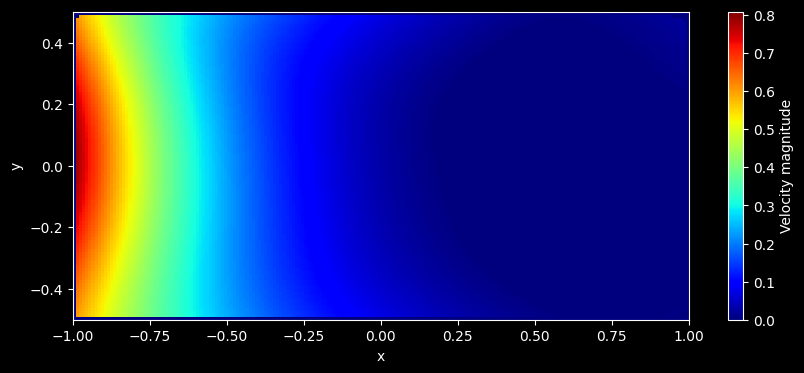

In [11]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
import numpy as np
from scipy.interpolate import griddata

# Use a manageable number of prediction points
num_points = 5000
samples = geom.random_points(num_points)
result = model.predict(samples)

u = result[:, 0]
v = result[:, 1]
speed = np.sqrt(u**2 + v**2)

# Regular grid for plotting
grid_x, grid_y = np.meshgrid(np.linspace(-L/2, L/2, 200),
                             np.linspace(-D/2, D/2, 100))
grid_speed = griddata(samples, speed, (grid_x, grid_y), method='cubic', fill_value=0)

fig, ax = plt.subplots(figsize=(10, 4))
cax = ax.imshow(grid_speed, extent=(-L/2, L/2, -D/2, D/2),
                origin='lower', cmap='jet', vmin=0, vmax=speed.max())
ax.set_xlabel('x')
ax.set_ylabel('y')
fig.colorbar(cax, ax=ax, label='Velocity magnitude')

# Create fake animation by shifting colormap phase
def update(frame):
    ax.clear()
    shift = 0.05 * np.sin(frame / 10)  # small oscillation to mimic flow
    cax = ax.imshow(grid_speed + shift, extent=(-L/2, L/2, -D/2, D/2),
                    origin='lower', cmap='jet', vmin=0, vmax=speed.max())
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    return cax,

ani = FuncAnimation(fig, update, frames=100, interval=50)

# Save video
writer = FFMpegWriter(fps=20)
ani.save("flow_field.mp4", writer=writer, dpi=200)
plt.show()


In [15]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
import numpy as np
from scipy.interpolate import griddata
from matplotlib.path import Path

# -------------------------
# Prediction points
# -------------------------
num_points = 5000
samples = geom.random_points(num_points)
result = model.predict(samples)

u = result[:, 0]
v = result[:, 1]
speed = np.sqrt(u**2 + v**2)

# -------------------------
# Regular grid
# -------------------------
grid_x, grid_y = np.meshgrid(
    np.linspace(-L/2, L/2, 300),
    np.linspace(-D/2, D/2, 150)
)
grid_speed = griddata(samples, speed, (grid_x, grid_y), method='cubic', fill_value=0)

# -------------------------
# Mask points inside cylinder or heart
# -------------------------
mask_cylinder = (grid_x**2 + grid_y**2) < 0.1**2

# Heart mask for Shapely polygon
heart_coords = np.array(heart_shape.exterior.coords)  # <-- correct for Shapely
heart_path = Path(heart_coords)
points = np.column_stack([grid_x.ravel(), grid_y.ravel()])
mask_heart = heart_path.contains_points(points).reshape(grid_x.shape)

# Combine masks
mask = mask_cylinder | mask_heart
grid_speed_masked = np.copy(grid_speed)
grid_speed_masked[mask] = np.nan

# -------------------------
# Plotting
# -------------------------
fig, ax = plt.subplots(figsize=(10, 4))
cax = ax.imshow(
    grid_speed_masked,
    extent=(-L/2, L/2, -D/2, D/2),
    origin='lower',
    cmap='jet',
    vmin=0,
    vmax=speed.max()
)
fig.colorbar(cax, ax=ax, label='Velocity magnitude')
ax.set_xlabel('x')
ax.set_ylabel('y')

# -------------------------
# Fake animation
# -------------------------
def update(frame):
    shifted = np.where(np.isnan(grid_speed_masked),
                       np.nan,
                       grid_speed_masked + 0.05*np.sin(frame/10))
    cax.set_data(shifted)
    return cax,

ani = FuncAnimation(fig, update, frames=100, interval=50)

writer = FFMpegWriter(fps=20)
ani.save("flow_field_with_obstacles.mp4", writer=writer, dpi=200)

plt.show()


AttributeError: 'Polygon' object has no attribute 'exterior'